# Initialization

In [3]:
import os 

%load_ext autoreload
%autoreload 2

os.chdir("/Users/antoineluciano/Documents/Recherche/permABC_new/permABC")


from vanilla import abc_vanilla, perm_abc_vanilla
from smc import abc_smc, perm_abc_smc
from over_sampling import perm_abc_smc_os
from under_matching import perm_abc_smc_um  
from kernels import KernelTruncatedRW
from distances import optimal_index_distance
from models.Gaussian_with_no_summary_stats import GaussianWithNoSummaryStats
from jax import random
import numpy as np
import jax.numpy as jnp
from scipy.stats import invgamma
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
key = random.PRNGKey(0)
key, subkey = random.split(key)
K = 15
n = 10
sigma0 = 10
alpha, beta = 5,5
model = GaussianWithNoSummaryStats(K = K, n_obs= n, sigma_0 = sigma0, alpha = alpha, beta = beta)
true_theta = model.prior_generator(subkey, 1)
# true_theta.loc = np.linspace(-2*sigma0, 2*sigma0, K)[None,:, None]
true_theta.glob = np.array([1.])[None,:]
key, subkey = random.split(key)
y_obs = model.data_generator(subkey, true_theta)
print(y_obs.shape)

(1, 15, 10)


# Vanilla 

## permABC

In [5]:
key, subkey = random.split(key)
N_points = 1000000
model.reset_weights_distance()
key, key_theta, key_perm = random.split(key, 3)
thetas = model.prior_generator(key_theta, N_points)
zs = model.data_generator(key, thetas)
dists_perm, ys_index, zs_index, _ = optimal_index_distance(model, zs, y_obs)
thetas_perm = thetas.apply_permutation(zs_index)

mus_perm_van = thetas_perm.loc.squeeze()
betas_perm_van = thetas_perm.glob.squeeze()

Minimum distance: 0.0001124188 Maximum distance: 245.82314 Number of NaNs: 0


## ABC

In [6]:
key, subkey = random.split(key)
zs_van, thetas_van, dists_van, n_sim_van = abc_vanilla(key = subkey, model = model, n_points = N_points, epsilon = np.inf, y_obs = y_obs)
mus_van = thetas_van.loc.squeeze()
betas_van = thetas_van.glob.squeeze()


# SMC

## ABC

In [7]:
kernel = KernelTruncatedRW 
key, subkey = random.split(key)
# epsilon = 0.
# N = 1000
N_smc = 1000
out_smc = abc_smc(key = subkey, model = model, n_particles= N_smc, epsilon_target= 0, y_obs = y_obs, kernel = kernel, verbose =1, Final_iteration = 0, update_weights_distance= False, N_sim_max= N_points*K, stopping_accept_rate= 0.)

mus_smc = out_smc['Thetas'][-1].loc.squeeze()
betas_smc = out_smc['Thetas'][-1].glob.squeeze()
n_sim = np.sum(out_smc["N_sim"])

Iteration 0: Epsilon = inf, ESS = 1000 Acc. rate = 100% Numb. unique particles = 1000
Iteration 1: Espilon = 234.1950, ESS = 950 Acc. rate = 1.37% Uniqueness rate particules = 100.0% Uniqueness rate components = 99.9% Global parameters uniqueness rate = 99.9%
NUMBER OF SIMULATIONS 29250/15000000

Iteration 2: Espilon = 211.6925, ESS = 902 Acc. rate = 1.11% Uniqueness rate particules = 100.0% Uniqueness rate components = 99.9% Global parameters uniqueness rate = 99.9%
NUMBER OF SIMULATIONS 42780/15000000

Iteration 3: Espilon = 202.6110, ESS = 856 Acc. rate = 1.05% Uniqueness rate particules = 100.0% Uniqueness rate components = 99.9% Global parameters uniqueness rate = 99.9%
NUMBER OF SIMULATIONS 55620/15000000

Iteration 4: Espilon = 189.9334, ESS = 813 Acc. rate = 0.49% Uniqueness rate particules = 100.0% Uniqueness rate components = 99.9% Global parameters uniqueness rate = 99.9%
NUMBER OF SIMULATIONS 67815/15000000

Iteration 5: Espilon = 183.0445, ESS = 772 Acc. rate = 1.04% Uniqu

## permABC

In [8]:
key, subkey = random.split(key)
kernel = KernelTruncatedRW
model.reset_weights_distance()
N_smc = 1000
out_perm_smc = perm_abc_smc(key = subkey, model = model, n_particles= N_smc, epsilon_target= 0, y_obs = y_obs, kernel = kernel, verbose = 1, Final_iteration= 0, update_weights_distance= False, N_sim_max= N_points*K, stopping_accept_rate= 0.)

mus_perm_smc = out_perm_smc["Thetas"][-1].loc.squeeze()
betas_perm_smc = out_perm_smc["Thetas"][-1].glob.squeeze()
n_sim_perm_smc = np.sum(out_perm_smc["N_sim"])

Minimum distance: 0.00057838025 Maximum distance: 148.275 Number of NaNs: 0
Iteration 0: Epsilon = inf, ESS = 1000 Acc. rate = 100% Numb. unique particles = 1000
Minimum distance: 0.00038595108 Maximum distance: 231.09857 Number of NaNs: 0
Iteration 2: Espilon = 36.0558, ESS = 950 Acc. rate = 18.84% Uniqueness rate particules = 100.0% Uniqueness rate components = 100.0% Global parameters uniqueness rate = 100.0%
NUMBER OF SIMULATIONS 29250/15000000

Minimum distance: 0.00040824874 Maximum distance: 222.08594 Number of NaNs: 0
Iteration 3: Espilon = 29.3164, ESS = 902 Acc. rate = 20.18% Uniqueness rate particules = 100.0% Uniqueness rate components = 100.0% Global parameters uniqueness rate = 100.0%
NUMBER OF SIMULATIONS 42780/15000000

Minimum distance: 0.0005910766 Maximum distance: 295.15866 Number of NaNs: 0
Iteration 4: Espilon = 26.4557, ESS = 856 Acc. rate = 21.26% Uniqueness rate particules = 100.0% Uniqueness rate components = 100.0% Global parameters uniqueness rate = 100.0%
N

/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:289: RuntimeWarning: overflow encountered in cast
  return _reduce_sum(a, axis=_ensure_optional_axes(axis), dtype=dtype, out=out,


Iteration 1137: Espilon = 0.2765, ESS = 1000 Acc. rate = 0.20% Uniqueness rate particules = 27.7% Uniqueness rate components = 27.7% Global parameters uniqueness rate = 27.7%
NUMBER OF SIMULATIONS 13085325/15000000

Minimum distance: 0.00034350008 Maximum distance: 81.898026 Number of NaNs: 0
Iteration 1138: Espilon = 0.2765, ESS = 1000 Acc. rate = 0.10% Uniqueness rate particules = 27.8% Uniqueness rate components = 27.8% Global parameters uniqueness rate = 27.8%
NUMBER OF SIMULATIONS 13100325/15000000

Minimum distance: 0.00015129155 Maximum distance: 82.47837 Number of NaNs: 0
Iteration 1139: Espilon = 0.2765, ESS = 1000 Acc. rate = 0.10% Uniqueness rate particules = 27.8% Uniqueness rate components = 27.8% Global parameters uniqueness rate = 27.8%
NUMBER OF SIMULATIONS 13115325/15000000

Minimum distance: 0.00046316077 Maximum distance: 83.150795 Number of NaNs: 0
Iteration 1140: Espilon = 0.2765, ESS = 1000 Acc. rate = 0.10% Uniqueness rate particules = 27.8% Uniqueness rate compo

/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:289: RuntimeWarning: overflow encountered in cast
  return _reduce_sum(a, axis=_ensure_optional_axes(axis), dtype=dtype, out=out,


Iteration 1191: Espilon = 0.2765, ESS = 1000 Acc. rate = 0.20% Uniqueness rate particules = 35.8% Uniqueness rate components = 35.8% Global parameters uniqueness rate = 35.8%
NUMBER OF SIMULATIONS 13895325/15000000

Minimum distance: 0.0005853497 Maximum distance: 83.63063 Number of NaNs: 0
Iteration 1192: Espilon = 0.2765, ESS = 1000 Acc. rate = 0.20% Uniqueness rate particules = 35.9% Uniqueness rate components = 35.9% Global parameters uniqueness rate = 35.9%
NUMBER OF SIMULATIONS 13910325/15000000

Minimum distance: 0.00030845645 Maximum distance: 79.017365 Number of NaNs: 0
Iteration 1193: Espilon = 0.2765, ESS = 1000 Acc. rate = 0.00% Uniqueness rate particules = 35.9% Uniqueness rate components = 35.9% Global parameters uniqueness rate = 35.9%
NUMBER OF SIMULATIONS 13925325/15000000

Minimum distance: 0.0003819933 Maximum distance: 80.812035 Number of NaNs: 0
Iteration 1194: Espilon = 0.2765, ESS = 1000 Acc. rate = 0.10% Uniqueness rate particules = 36.0% Uniqueness rate compone

In [9]:
# N_plot = 3

# f, ax = plt.subplots(1, N_plot + 1, figsize=(15, 5))
# if N_plot < K:
#     perm = np.random.permutation(K)
# else:
#     perm = np.arange(K)

# for i in range(N_plot):
#     k = perm[i]
#     sns.kdeplot(np.unique(mus_perm_van[dists_perm<epsilon, k][:N]), ax=ax[i], label="Perm ABC vanilla")
#     # sns.kdeplot(np.unique(mus_van[:, k]), ax=ax[i], label="ABC vanilla")
#     # sns.kdeplot(np.unique(mus_smc[:, k]), ax=ax[i], label="ABC SMC")
#     sns.kdeplot(np.unique(mus_perm_smc[:, k][:N]), ax=ax[i], label="Perm ABC SMC")
#     # sns.kdeplot(np.unique(mus_os[:, k]), ax=ax[i], label="Perm ABC SMC OS")
#     # sns.kdeplot(np.unique(mus_um[:, k]), ax=ax[i], label="Perm ABC SMC UM")
#     ax[i].axvline(true_theta.loc[0, k], color="black", linestyle="--")
#     ax[i].set_title("Component {}".format(k))
#     # ax[i].legend()
#     ax[i].set_xlabel(r"$\mu_{}$".format(k))
#     ax[i].set_ylabel("Density")

# sns.kdeplot(np.unique(betas_perm_van[dists_perm<epsilon][:N]), ax=ax[-1], label="Perm ABC vanilla")
# # sns.kdeplot(np.unique(betas_van), ax=ax[-1], label="ABC vanilla")
# # sns.kdeplot(np.unique(betas_smc), ax=ax[-1], label="ABC SMC", fill=True)
# sns.kdeplot(np.unique(betas_perm_smc)[:N], ax=ax[-1], label="Perm ABC SMC")
# # sns.kdeplot(np.unique(betas_os), ax=ax[-1], label="Perm ABC SMC OS")
# # sns.kdeplot(np.unique(betas_um), ax=ax[-1], label="Perm ABC SMC UM")
# ax[-1].axvline(true_theta.glob[0], color="black", linestyle="--")
# ax[-1].set_title("Global parameter")
# ax[-1].legend()
# ax[-1].set_xlabel(r"$\beta$")
# ax[-1].set_ylabel("Density")
# ax[-1].set_xlim(0, 5)
# plt.tight_layout()
# plt.show()

## Over Sampling

In [10]:
# M0 = 50
# key = random.PRNGKey(0)
# key, subkey = random.split(key)
# kernel = KernelTruncatedRW
# model.reset_weights_distance()
# os = perm_abc_smc_os(key = subkey, model = model, n_particles= N, epsilon = epsilon, y_obs = y_obs, kernel = kernel, verbose = 3, M_0 = M0, duplicate= True, n_duplicate = 0, alpha_M = .9, Final_iteration= 50, update_weights_distance= False)
# mus_os = os["Thetas"][-1].loc.squeeze()
# betas_os = os["Thetas"][-1].glob.squeeze()
# n_sim_os = np.sum(os["N_sim"])

## Under Matching 

In [11]:
# L0 = 3
# key = random.PRNGKey(0)
# key, subkey = random.split(key)
# kernel = KernelTruncatedRW
# model.reset_weights_distance()
# um = perm_abc_smc_um(key = subkey, model = model, n_particles= N, epsilon = epsilon, y_obs = y_obs, kernel = kernel, verbose = 3, L_0 = L0,  alpha_L = .75, alpha_epsilon= .75,Final_iteration= 50, update_weights_distance= False)

# mus_um = um["Thetas"][-1].loc.squeeze()
# betas_um = um["Thetas"][-1].glob.squeeze()
# n_sim_um = np.sum(um["N_sim"])

## ABC-PMC

In [12]:
from pmc import abc_pmc

In [13]:
key, subkey = random.split(key)
model.reset_weights_distance()
N_smc = 1000
out_pmc = abc_pmc(key = subkey, model = model, n_particles= N_smc, epsilon_target= 0, y_obs = y_obs, verbose =1, update_weights_distance= False, N_sim_max= N_points*K, stopping_accept_rate= 0., alpha = .95)

DISTANCE VALUES: MIN = 43.1, MAX = 3.57e+02 MEAN = 1.54e+02
Iteration 0: Epsilon = inf ESS = 1000 (100.000%)
Iteration 1: Epsilon = 2.35e+02
Std loc: min = 13.5, max = 14.9
Std glob = 0.888
Simulating...
NUMBER OF SIMULATIONS: 62310/15000000
Number of simulations: 3.15E+03 (Accept rate 31.70577%)
Weight update...
DISTANCE VALUES: MIN = 43.3, MAX = 2.35e+02 MEAN = 1.86e+02
Log Denominateur: min = -70.2 (index = 315), max = -58.4 (index = 600)
Log prior: min -1.674e+03 (index = 140), max = -51.16 (index = 600)
Weights: min = 0.0 (index = 54), max = 0.314 (index = 600)
ESS = 9 (0.856%)
Resampling...
Number of unique index:  4 1
Number of unique particles: 124
After resampling, new thetas shape: (1000, 15, 1)

Iteration 2: Epsilon = 2.14e+02
Std loc: min = 10.2, max = 15.0
Std glob = 0.624
Simulating...
NUMBER OF SIMULATIONS: 108525/15000000
Number of simulations: 3.08E+03 (Accept rate 32.45699%)
Weight update...
DISTANCE VALUES: MIN = 51.5, MAX = 2.14e+02 MEAN = 1.64e+02
Log Denominateur:

# Comparison

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

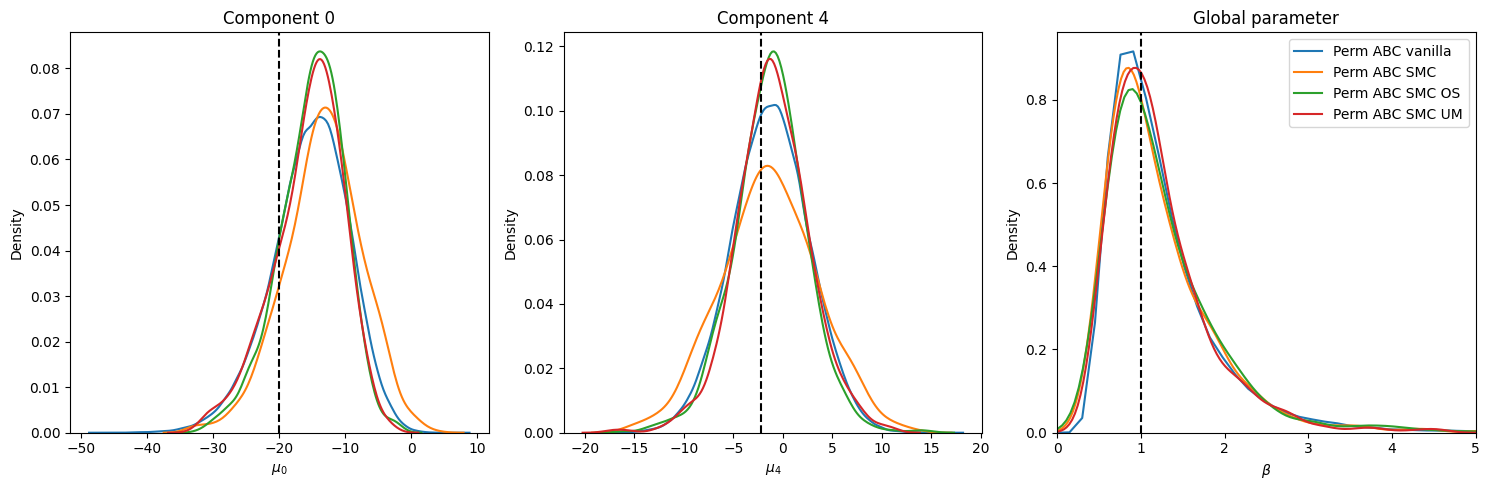

In [ ]:
# N_plot = 2

# f, ax = plt.subplots(1, N_plot + 1, figsize=(15, 5))
# if N_plot < K:
#     perm = np.random.permutation(K)
# else:
#     perm = np.arange(K)

# for i in range(N_plot):
#     k = perm[i]
#     sns.kdeplot(np.unique(mus_perm_van[dists_perm<epsilon, k]), ax=ax[i], label="Perm ABC vanilla")
#     # sns.kdeplot(np.unique(mus_van[:, k]), ax=ax[i], label="ABC vanilla")
#     # sns.kdeplot(np.unique(mus_smc[:, k]), ax=ax[i], label="ABC SMC")
#     sns.kdeplot(np.unique(mus_perm_smc[:, k]), ax=ax[i], label="Perm ABC SMC")
#     sns.kdeplot(np.unique(mus_os[:, k]), ax=ax[i], label="Perm ABC SMC OS")
#     sns.kdeplot(np.unique(mus_um[:, k]), ax=ax[i], label="Perm ABC SMC UM")
#     ax[i].axvline(true_theta.loc[0, k], color="black", linestyle="--")
#     ax[i].set_title("Component {}".format(k))
#     # ax[i].legend()
#     ax[i].set_xlabel(r"$\mu_{}$".format(k))
#     ax[i].set_ylabel("Density")

# sns.kdeplot(np.unique(betas_perm_van[dists_perm<epsilon]), ax=ax[-1], label="Perm ABC vanilla")
# # sns.kdeplot(np.unique(betas_van), ax=ax[-1], label="ABC vanilla")
# # sns.kdeplot(np.unique(betas_smc), ax=ax[-1], label="ABC SMC", fill=True)
# sns.kdeplot(np.unique(betas_perm_smc), ax=ax[-1], label="Perm ABC SMC")
# sns.kdeplot(np.unique(betas_os), ax=ax[-1], label="Perm ABC SMC OS")
# sns.kdeplot(np.unique(betas_um), ax=ax[-1], label="Perm ABC SMC UM")
# ax[-1].axvline(true_theta.glob[0], color="black", linestyle="--")
# ax[-1].set_title("Global parameter")
# ax[-1].legend()
# ax[-1].set_xlabel(r"$\beta$")
# ax[-1].set_ylabel("Density")
# ax[-1].set_xlim(0, 5)
# plt.tight_layout()
# plt.show()

# Plot

In [14]:
n_sim_smc = np.array(out_smc["N_sim"])
n_sim_perm_smc = np.array(out_perm_smc["N_sim"])
epsilon_smc = np.array(out_smc["Eps_values"])
epsilon_perm_smc = np.array(out_perm_smc["Eps_values"])
unique_smc = np.array(out_smc["unique_part"])
unique_perm_smc = np.array(out_perm_smc["unique_part"])
epsilon_pmc = np.array(out_pmc["Eps_values"])
n_sim_pmc = np.array(out_pmc["N_sim"])
ess_pmc = np.array(out_pmc["Ess"])
unique_pmc = np.array(out_pmc["unique_part"])


In [15]:
epsilon_smc[0] = epsilon_smc[1]
epsilon_perm_smc[0] = epsilon_perm_smc[1]
epsilon_pmc[0] = epsilon_pmc[1]


In [16]:
len(n_sim_smc), len(unique_smc), len(epsilon_smc), len(n_sim_perm_smc), len(unique_perm_smc), len(epsilon_perm_smc), len(n_sim_pmc), len(epsilon_pmc), len(ess_pmc)

(1418, 1418, 1418, 1266, 1266, 1266, 79, 79, 79)

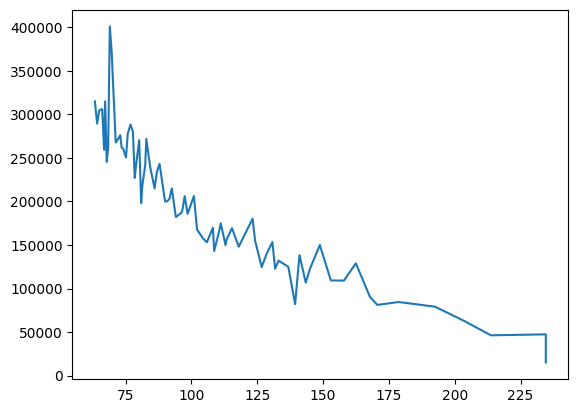

In [17]:
plt.plot(epsilon_pmc, n_sim_pmc, label="PMC")


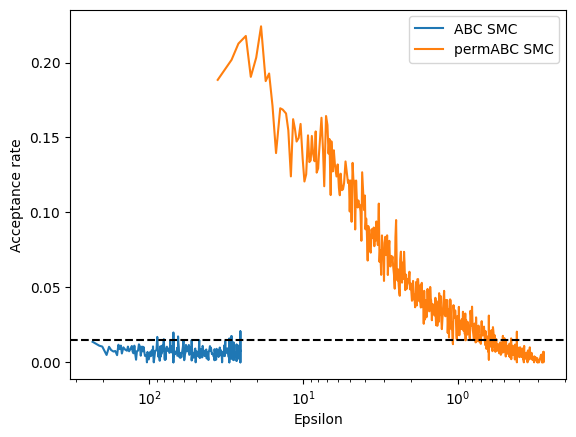

In [18]:
plt.plot(epsilon_smc[1:], out_smc["Acc_rate"][1:], label="ABC SMC")
plt.plot(epsilon_perm_smc[1:], out_perm_smc["Acc_rate"][1:], label="permABC SMC")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("Epsilon")
plt.ylabel("Acceptance rate")
plt.axhline(0.015, color="black", linestyle="--")
plt.legend()


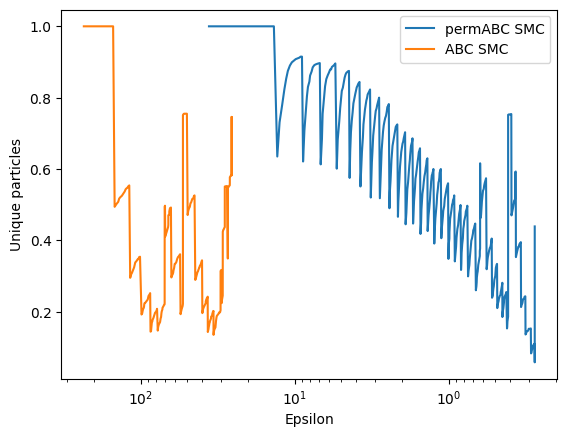

In [19]:
plt.plot(epsilon_perm_smc[1:], unique_perm_smc[1:], label="permABC SMC")
plt.plot(epsilon_smc[1:], unique_smc[1:], label="ABC SMC")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("Epsilon")
plt.ylabel("Unique particles")
plt.legend()


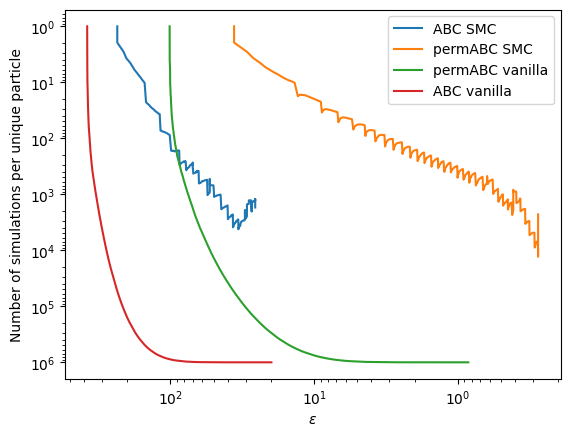

In [20]:
plt.plot(epsilon_smc, np.cumsum(n_sim_smc)/K/1000/unique_smc, label="ABC SMC")
plt.plot(epsilon_perm_smc, np.cumsum(n_sim_perm_smc)/K/1000/unique_perm_smc, label="permABC SMC")
plt.plot(np.sort(dists_perm)[::-1][100:], np.arange(1, N_points+1-100), label="permABC vanilla")
plt.plot(np.sort(dists_van[:,0])[::-1][100:], np.arange(1, N_points+1-100), label="ABC vanilla")
plt.yscale("log")
plt.xscale("log")

plt.ylabel("Number of simulations per unique particle")
plt.xlabel(r"$\epsilon$")

plt.legend()
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


In [21]:
N_sim_pmc = np.cumsum(n_sim_pmc)/K/unique_pmc/1000*N_sample
plt.plot(N_sim_pmc, epsilon_pmc, label="ABC-PMC")
plt.plot(N_sim_smc, epsilon_smc, label="ABC-SMC")
plt.legend()
plt.xscale("log")
plt.yscale("log")

NameError: name 'N_sample' is not defined

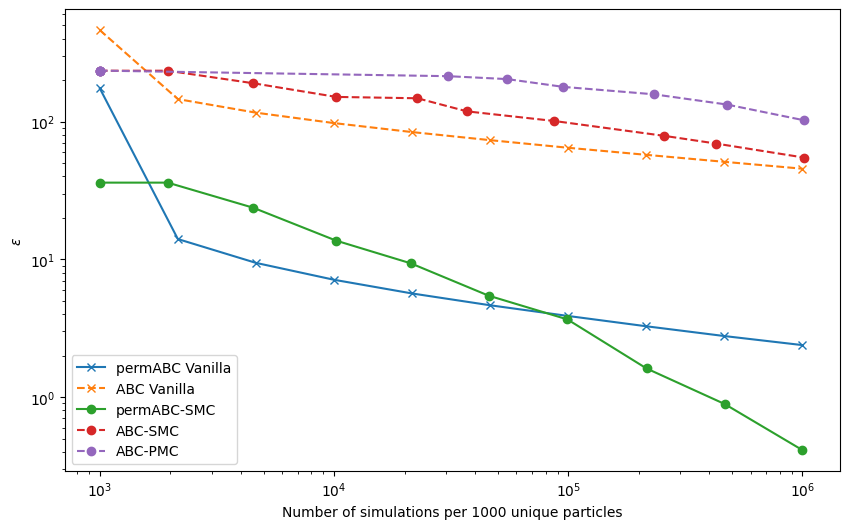

In [ ]:
N_sample = 1000

alphas = np.logspace(0, -3, 10)
epsilons_van_perm = np.quantile(dists_perm, alphas)
epsilons_van = np.quantile(dists_van[:,0], alphas)

N_sims = N_sample/alphas

N_sim_pmc = np.cumsum(n_sim_pmc)/K/unique_pmc/1000*N_sample
N_sim_smc = np.cumsum(n_sim_smc)/K/unique_smc/1000*N_sample
N_sim_perm_smc = np.cumsum(n_sim_perm_smc)/K/unique_perm_smc/1000*N_sample


closest_index_smc = np.argmin(np.abs(N_sim_smc - N_sims[:, None]), axis=1)
closest_index_perm_smc = np.argmin(np.abs(N_sim_perm_smc - N_sims[:, None]), axis=1)
closest_index_pmc = np.argmin(np.abs(N_sim_pmc - N_sims[:, None]), axis=1)
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(N_sims, np.quantile(dists_perm, alphas), label="permABC Vanilla", linestyle="-", marker="x")
plt.plot(N_sims, np.quantile(dists_van[:,0], alphas), label="ABC Vanilla", linestyle="--", marker="x")
plt.plot(N_sim_perm_smc[closest_index_perm_smc], epsilon_perm_smc[closest_index_perm_smc], label="permABC-SMC", linestyle="-", marker="o")
plt.plot(N_sim_smc[closest_index_smc], epsilon_smc[closest_index_smc], label="ABC-SMC", linestyle="--", marker="o")
plt.plot(N_sim_pmc[closest_index_pmc], epsilon_pmc[closest_index_pmc], label="ABC-PMC", linestyle="--", marker="o")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of simulations per {} unique particles".format(N_sample)) 
plt.ylabel(r"$\epsilon$")
plt.legend()
# plt.gca().invert_xaxis()



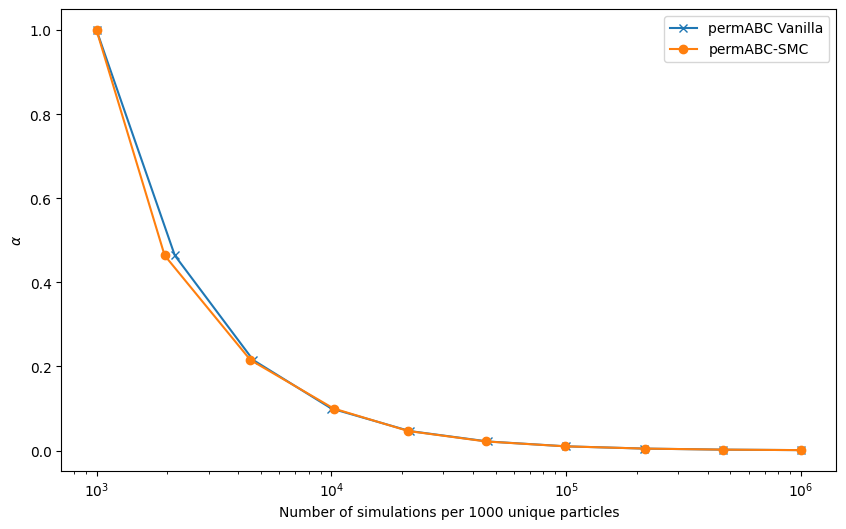

In [32]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(N_sims, alphas, label="permABC Vanilla", linestyle="-", marker="x")
# plt.plot(N_sims, alphas, label="ABC Vanilla", linestyle="--", marker="x")
plt.plot(N_sim_perm_smc[closest_index_perm_smc], alphas, label="permABC-SMC", linestyle="-", marker="o")
# plt.plot(N_sim_smc[closest_index_smc], alphas, label="ABC-SMC", linestyle="--", marker="o")
# plt.plot(N_sim_pmc[closest_index_pmc], alphas, label="ABC-PMC", linestyle="--", marker="o")

# plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of simulations per {} unique particles".format(N_sample)) 
plt.ylabel(r"$\alpha$")
plt.legend()
# plt.gca().invert_xaxis()


In [25]:
import pickle

data_to_save = {
    "N_sample": N_sample,
    "alphas": alphas,
    "dists_perm": dists_perm,
    "dists_van": dists_van,
    "n_sim_pmc": n_sim_pmc,
    "n_sim_smc": n_sim_smc,
    "n_sim_perm_smc": n_sim_perm_smc,
    "epsilon_pmc": epsilon_pmc,
    "epsilon_smc": epsilon_smc,
    "epsilon_perm_smc": epsilon_perm_smc,
    "unique_pmc": unique_pmc,
    "unique_smc": unique_smc,
    "unique_perm_smc": unique_perm_smc,
}

with open("plot_comparison_vanilla_smc.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

# Save outs


In [ ]:
import lzma
import pickle

# Save out_smc
with lzma.open("out_smc.xz", "wb") as f:
    pickle.dump(out_smc, f)

# Save out_perm_smc
with lzma.open("out_perm_smc.xz", "wb") as f:
    pickle.dump(out_perm_smc, f)

In [ ]:
# from tqdm.notebook import tqdm 
# N = 1000

# kernel = KernelTruncatedRW
# alphas = [.99,.95,.9,.95,.75,.5,.25,.1,.05,.01]
# nsim_perm_van = N/np.array(alphas)
# epsilons= np.quantile(dists_perm, alphas)
# alpha_L = .95
# alphas_M = [.9, .75, .5]
# M0s = [100, 50, 25]
# L0s = [1, 2, 3, 4]
# N_sims = {"OS": {}, "UM": {}, "SMC": []}

# for M0 in M0s:
#     N_sims["OS"][M0] = {}
#     for alpha_M in alphas_M:
#         N_sims["OS"][M0][alpha_M] = []
# for L0 in L0s:
#     N_sims["UM"][L0] = []
    
# Unique = {"OS": {}, "UM": {} , "SMC": []}
# for M0 in M0s:
#     Unique["OS"][M0] = {}
#     for alpha_M in alphas_M:
#         Unique["OS"][M0][alpha_M] = []
# for L0 in L0s:
#     Unique["UM"][L0] = []
    

# for epsilon in tqdm(epsilons):
#     print(epsilon)
#     key, subkey = random.split(key)
#     print("Perm ABC SMC")
#     out_perm_smc = perm_abc_smc(key = subkey, model = model, n_particles= N, epsilon_target= epsilon, y_obs = y_obs, kernel = kernel, verbose = 0)
#     N_sims["SMC"].append(np.sum(out_perm_smc["N_sim"]))
#     Unique["SMC"].append(len(np.unique(out_perm_smc["Thetas"][-1].loc, axis = 0)))
#     print("Perm ABC SMC OS")
#     for M0 in M0s:
#         for alpha_M in alphas_M:
#             key, subkey = random.split(key)
#             os = perm_abc_smc_os(key = subkey, model = model, n_particles= N, epsilon = epsilon, y_obs = y_obs, kernel = kernel, verbose = 0, M_0 = M0, duplicate= True, n_duplicate = 0, alpha_M = alpha_M)
#             N_sims["OS"][M0][alpha_M].append(np.sum(os["N_sim"]))
#             Unique["OS"][M0][alpha_M].append(len(np.unique(os["Thetas"][-1].loc, axis = 0)))
#     print("Perm ABC SMC UM")
#     for L0 in L0s:
#         key, subkey = random.split(key)
#         um = perm_abc_smc_um(key = subkey, model = model, n_particles= N, epsilon = epsilon, y_obs = y_obs, kernel = kernel, verbose = 0, L_0 = L0)
#         N_sims["UM"][L0].append(np.sum(um["N_sim"]))
#         Unique["UM"][L0].append(len(np.unique(um["Thetas"][-1].loc, axis = 0)))
        
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

102.76838851928709
Perm ABC SMC
Perm ABC SMC OS
(2000, 100) 2
(2000, 91) 2
(2000, 82) 2
(2000, 74) 2
(2000, 67) 2
(2000, 61) 2
(2000, 55) 2
(2000, 50) 2
(2000, 46) 2
(2000, 42) 2
(2000, 38) 2
(2000, 35) 2
(2000, 32) 2
(2000, 29) 2
(2000, 27) 2
(2000, 25) 2
(2000, 23) 2
(3000, 21) 3
(2000, 18) 2
(2000, 17) 2
(2000, 16) 2
(2000, 15) 2
(3000, 14) 3
(3000, 13) 3
(5000, 12) 5
(9000, 11) 9
(11000, 100) 11
(10000, 77) 10
(10000, 60) 10
(11000, 47) 11
(8000, 37) 8
(6000, 30) 6
(6000, 25) 6
(6000, 21) 6
(4000, 18) 4
(5000, 16) 5
(2000, 14) 2
(3000, 13) 3
(4000, 12) 4
(8000, 11) 8


KeyboardInterrupt: 

Probleme permSMC ? Acc plus faible que OS et UM pour meme epsilon!!!